In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from scipy.stats import boxcox, chi2, chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from itertools import combinations

In [2]:
# Titanic Datensatz laden
data = pd.read_csv('train.csv')

In [3]:
#data = sns.load_dataset('titanic')

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Fehlende Werte

In [5]:
# Erstellen eines Beispieldatensatzes mit fehlenden Werten
dat = {
    'Name': ['John', 'Alice', 'Bob', 'Emma', 'Tom'],
    'Age': [20, np.nan, 22, 19, 18],
    'TestScore': [85, 90, np.nan, 78, 92],
    'Grade': ['A', 'B', np.nan, 'C', 'A']
}
df = pd.DataFrame(dat)

print("Original Dataset:")
df

Original Dataset:


,Name,Age,TestScore,Grade
0,John,20.0,85.0,A
1,Alice,NaN,90.0,B
2,Bob,22.0,NaN,NaN
3,Emma,19.0,78.0,C
4,Tom,18.0,92.0,A


In [6]:
# Anzahl fehlender Werte in jeder Spalte anzeigen
missing = df.isnull().sum()
missing

Name         0
Age          1
TestScore    1
Grade        1
dtype: int64

In [7]:
# Anzahl fehlender Werte in jeder Spalte anzeigen - Titanic Datensatz
missing_values = data.isnull().sum()
missing_values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# Set a random seed for reproducibility
np.random.seed(0)

# Choose 20 random indices to set to NaN in the 'Fare' column
random_indices = np.random.choice(data.index, size=40, replace=False)

# Set the selected 'Fare' values to NaN
data.loc[random_indices, 'Fare'] = np.nan

In [9]:
# Speichern der Indizes der Zeilen mit fehlenden Alterswerten
missing_age_indices = data[data['Age'].isnull()].index
# Finden Sie die Indizes, bei denen sowohl 'Age' als auch 'Fare' fehlende Werte haben
missing_age_fare_indices = data[data['Age'].isnull() & data['Fare'].isnull()].index

In [10]:
# Anzeigen der Zeilen mit den ursprünglich fehlenden Alterswerten nach der Imputation
data.loc[missing_age_indices].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [11]:
data.loc[missing_age_fare_indices].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,NaN,B78,C
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,NaN,C52,S
196,197,0,3,"Mernagh, Mr. Robert",male,NaN,0,0,368703,NaN,NaN,Q
270,271,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,NaN,NaN,S
298,299,1,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,NaN,C106,S


### Mittelwert/Median/Modus-Imputation

In [12]:
data = pd.read_csv('train.csv')

In [13]:
# Mittelwert
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [14]:
# Median
data['Age'] = data['Age'].fillna(data['Age'].median())

In [15]:
# Modus (häufigster Wert)
data['Age'] = data['Age'].fillna(data['Age'].mode()[0])

In [16]:
data.loc[missing_age_indices].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,29.699118,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,29.699118,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,29.699118,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,29.699118,0,0,330959,7.8792,NaN,Q


Das kann man auch anders implementieren:

In [17]:
# SimpleImputer erstellen, um fehlende Werte mit dem Mittelwert zu füllen
imputer = SimpleImputer(strategy='mean')

# Imputer anwenden auf die 'Age'-Spalte und die Werte zurück in 'data' schreiben
data['Age'] = imputer.fit_transform(data[['Age']])

In [18]:
# Verwenden der Mittelwert-/Median-/Modus-Imputation
imputer = SimpleImputer(strategy='mean')  # Andere Strategien: 'median', 'most_frequent' für Modus
df[['Age', 'TestScore']] = imputer.fit_transform(df[['Age', 'TestScore']])

print("Nach Mean/Median Imputation:")
print(df)

Nach Mean/Median Imputation:
    Name    Age  TestScore Grade
0   John  20.00      85.00     A
1  Alice  19.75      90.00     B
2    Bob  22.00      86.25   NaN
3   Emma  19.00      78.00     C
4    Tom  18.00      92.00     A


### Forward Fill/Backward Fill

In [19]:
data = pd.read_csv('train.csv')

In [20]:
# Forward Fill
data['Age'] = data['Age'].ffill()

In [21]:
# Backward Fill
data['Age'] = data['Age'].bfill()

In [22]:
data.loc[missing_age_indices].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,35.0,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,2.0,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,31.0,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,38.0,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,19.0,0,0,330959,7.8792,NaN,Q


Diese Methode macht hier offensichtlich keinen Sinn!

### Regression zur Vorhersage fehlender Werte

In [23]:
data = pd.read_csv('train.csv')

In [24]:
# Datensätze mit und ohne fehlende Werte trennen
train_data = data[data['Age'].notnull()]
test_data = data[data['Age'].isnull()]

# Modell erstellen und trainieren
regressor = LinearRegression()
regressor.fit(train_data[['Fare', 'Pclass', 'SibSp']], train_data['Age'])

# Vorhersage der fehlenden Werte
data.loc[data['Age'].isnull(), 'Age'] = regressor.predict(test_data[['Fare', 'Pclass', 'SibSp']])

In [25]:
data.loc[missing_age_indices].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,27.198219,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,34.022486,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,27.228171,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,27.228171,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,27.212283,0,0,330959,7.8792,NaN,Q


### Iterative Imputation

In [26]:
data = pd.read_csv('train.csv')

In [27]:
imputer = IterativeImputer()
data[['Age', 'Fare']] = imputer.fit_transform(data[['Age', 'Fare']])

In [28]:
data.loc[missing_age_fare_indices].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,32.207043,1,0,PC 17569,146.5208,B78,C
55,56,1,1,"Woolner, Mr. Hugh",male,29.717182,0,0,19947,35.5000,C52,S
196,197,0,3,"Mernagh, Mr. Robert",male,29.094834,0,0,368703,7.7500,NaN,Q
270,271,0,1,"Cairns, Mr. Alexander",male,29.616261,0,0,113798,31.0000,NaN,S
298,299,1,1,"Saalfeld, Mr. Adolphe",male,29.605047,0,0,19988,30.5000,C106,S


## 2. Kategorische Variablen

In [29]:
# Erstellen des ursprünglichen Datensatzes
df = pd.DataFrame({
    'Fruit': ['Apple', 'Banana', 'Orange', 'Apple', 'Banana'],
    'Color': ['Red', 'Yellow', 'Orange', 'Green', 'Yellow'],
    'Tastes_Good': [1, 0, 0, 1, 1]
})

print("Original Dataset:")
df

Original Dataset:


,Fruit,Color,Tastes_Good
0,Apple,Red,1
1,Banana,Yellow,0
2,Orange,Orange,0
3,Apple,Green,1
4,Banana,Yellow,1


### One-Hot Encoding

In [30]:
# One-Hot Encoding anwenden
data_encoded = pd.get_dummies(df, columns=['Fruit', 'Color'])

print("\nNach One-Hot Encoding:")
data_encoded


Nach One-Hot Encoding:


,Tastes_Good,Fruit_Apple,Fruit_Banana,Fruit_Orange,Color_Green,Color_Orange,Color_Red,Color_Yellow
0,1,True,False,False,False,False,True,False
1,0,False,True,False,False,False,False,True
2,0,False,False,True,False,True,False,False
3,1,True,False,False,True,False,False,False
4,1,False,True,False,False,False,False,True


In [31]:
# 1. One-Hot Encoding mit OneHotEncoder von Scikit-Learn
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Erstes Level droppen (Multikollinearität)
one_hot_encoded = one_hot_encoder.fit_transform(df[['Fruit', 'Color']])
feature_names = one_hot_encoder.get_feature_names_out(['Fruit', 'Color'])
df_one_hot = pd.DataFrame(one_hot_encoded, columns=feature_names)

# Originale kategorische Spalten entfernen und One-Hot-kodierte Spalten hinzufügen
df_encoded = pd.concat([df.drop(['Fruit', 'Color'], axis=1), df_one_hot], axis=1)

print("\nNach One-Hot Encoding:")
df_encoded


Nach One-Hot Encoding:


,Tastes_Good,Fruit_Banana,Fruit_Orange,Color_Orange,Color_Red,Color_Yellow
0,1,0.0,0.0,0.0,1.0,0.0
1,0,1.0,0.0,0.0,0.0,1.0
2,0,0.0,1.0,1.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,1.0


### Label Encoding

In [32]:
# Label Encoding
label_encoder = LabelEncoder()
df_label_encoded = df.copy()
df_label_encoded['Fruit'] = label_encoder.fit_transform(df['Fruit'])
df_label_encoded['Color'] = label_encoder.fit_transform(df['Color'])

print("\nNach Label Encoding:")
df_label_encoded


Nach Label Encoding:


,Fruit,Color,Tastes_Good
0,0,2,1
1,1,3,0
2,2,1,0
3,0,0,1
4,1,3,1


### Target Encoding

In [33]:
# Target Encoding für die Spalten 'Fruit' und 'Color' basierend auf der Zielvariable 'Target'
target_encoder = TargetEncoder()
df_target_encoded = df.copy()
df_target_encoded[['Fruit']] = target_encoder.fit_transform(df[['Fruit']], df['Tastes_Good'])
#df_target_encoded[['Color']] = target_encoder.fit_transform(df[['Color']], df['Tastes_Good'])

print("\nNach Target Encoding:")
print(df_target_encoded)


Nach Target Encoding:
      Fruit   Color  Tastes_Good
0  0.656740     Red            1
1  0.585815  Yellow            0
2  0.521935  Orange            0
3  0.656740   Green            1
4  0.585815  Yellow            1


In [34]:
target_encoder = TargetEncoder(smoothing=0.0001, min_samples_leaf=1)
df_target_encoded = df.copy()
df_target_encoded[['Fruit']] = target_encoder.fit_transform(df[['Fruit']], df['Tastes_Good'])
#df_target_encoded[['Color']] = target_encoder.fit_transform(df[['Color']], df['Tastes_Good'])

print("\nNach Target Encoding:")
print(df_target_encoded)


Nach Target Encoding:
   Fruit   Color  Tastes_Good
0    1.0     Red            1
1    0.5  Yellow            0
2    0.3  Orange            0
3    1.0   Green            1
4    0.5  Yellow            1


In [35]:
# Direkter Durchschnitt ohne Smoothing
df['Fruit_Encoded'] = df.groupby('Fruit')['Tastes_Good'].transform('mean')
df['Color_Encoded'] = df.groupby('Color')['Tastes_Good'].transform('mean')
print("\nDirektes Target Encoding ohne Smoothing:")
print(df)


Direktes Target Encoding ohne Smoothing:
    Fruit   Color  Tastes_Good  Fruit_Encoded  Color_Encoded
0   Apple     Red            1            1.0            1.0
1  Banana  Yellow            0            0.5            0.5
2  Orange  Orange            0            0.0            0.0
3   Apple   Green            1            1.0            1.0
4  Banana  Yellow            1            0.5            0.5


### Kategorisch machen: Binning

In [36]:
# Beispiel-Daten für Alter
dat = pd.DataFrame({'Age': [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]})

#### Fixed Binning

In [37]:
# Fixed Binning in Altersgruppen
age_bins = [0, 18, 35, 50, 65]
age_labels = ['Child', 'Young Adult', 'Adult', 'Senior']
dat['Age_Group_Fixed'] = pd.cut(dat['Age'], bins=age_bins, labels=age_labels)

print("Fixed Binning:")
dat

Fixed Binning:


,Age,Age_Group_Fixed
0,15,Child
1,20,Young Adult
2,25,Young Adult
3,30,Young Adult
4,35,Young Adult
5,40,Adult
6,45,Adult
7,50,Adult
8,55,Senior
9,60,Senior


#### Quantil-Binning

In [38]:
# Quantile Binning in vier gleiche Gruppen
dat['Age_Group_Quantile'] = pd.qcut(dat['Age'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

print("\nQuantile Binning:")
dat


Quantile Binning:


,Age,Age_Group_Fixed,Age_Group_Quantile
0,15,Child,Q1
1,20,Young Adult,Q1
2,25,Young Adult,Q1
3,30,Young Adult,Q2
4,35,Young Adult,Q2
5,40,Adult,Q3
6,45,Adult,Q3
7,50,Adult,Q4
8,55,Senior,Q4
9,60,Senior,Q4


## 3. Ausreißer

In [39]:
# Erstellen eines größeren Beispieldatensatzes mit mehr Werten
np.random.seed(0)  # Für Reproduzierbarkeit
scores = np.random.normal(loc=50, scale=10, size=100).tolist()  # Normale Verteilung um 50 mit Streuung von 10
scores += [120, 130, 500]  # Hinzufügen einiger Ausreißer

dat = pd.DataFrame({'Score': scores})

### Ausreißer identifizieren

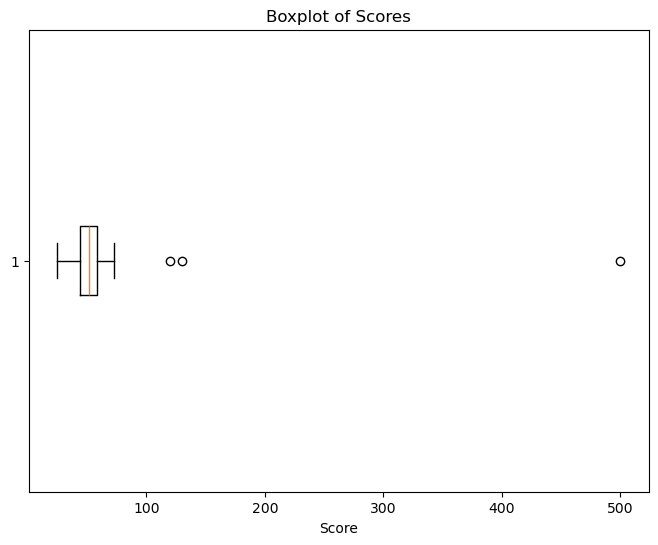

In [40]:
# Boxplot plotten
plt.figure(figsize=(8, 6))
plt.boxplot(dat['Score'], vert=False)
plt.title("Boxplot of Scores")
plt.xlabel("Score")
plt.show()

In [41]:
# Berechnung des Interquartilsabstands (IQR)
Q1 = dat['Score'].quantile(0.25)
Q3 = dat['Score'].quantile(0.75)
IQR = Q3 - Q1

# Festlegung der Grenzen
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [42]:
# Identifizierung der Ausreißer
outliers = dat[(dat['Score'] < lower_bound) | (dat['Score'] > upper_bound)]
print("Ausreißer:\n", outliers)

Ausreißer:
      Score
100  120.0
101  130.0
102  500.0


### Entfernen der Ausreißer

In [43]:
# Entfernen von Ausreißern aus dem Datensatz
dat_no_outliers = dat[(dat['Score'] >= lower_bound) & (dat['Score'] <= upper_bound)]

In [44]:
# Winsorizing: Deckelung der Werte auf die Grenzwerte
dat['Score'] = dat['Score'].clip(lower_bound, upper_bound)

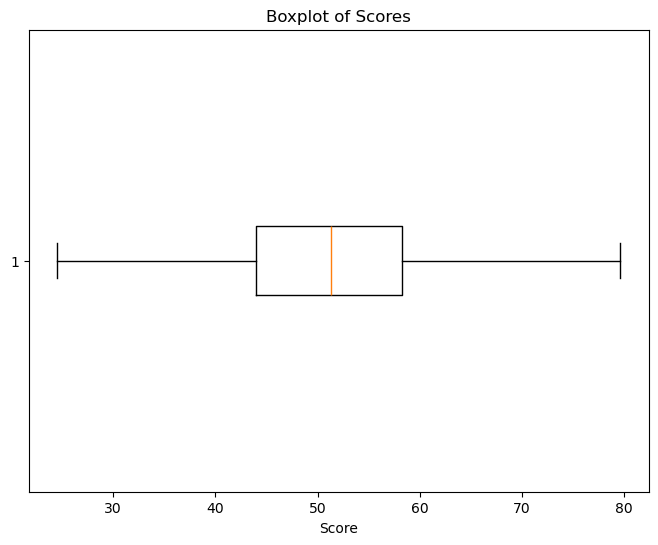

In [45]:
# Boxplot plotten
plt.figure(figsize=(8, 6))
plt.boxplot(dat['Score'], vert=False)
plt.title("Boxplot of Scores")
plt.xlabel("Score")
plt.show()

Anwendung auf Titanic Daten:

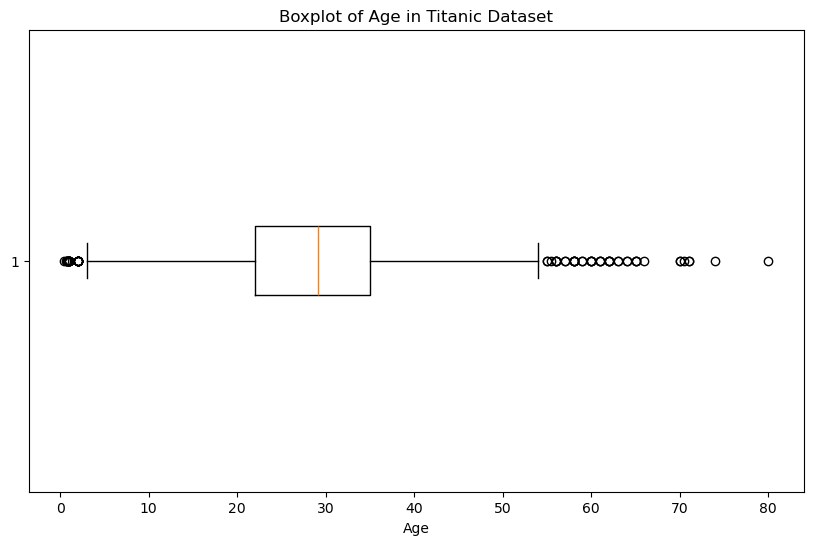

In [46]:
# Boxplot für die Spalte 'Age'
plt.figure(figsize=(10, 6))
plt.boxplot(data['Age'].dropna(), vert=False)  # Nur gültige Alterswerte verwenden
plt.title("Boxplot of Age in Titanic Dataset")
plt.xlabel("Age")
plt.show()

Hier würde man offensichtlich nicht die "Ausreißer" laut Boxplot löschen.

## 4. Transformation und Skalierung von Merkmalen

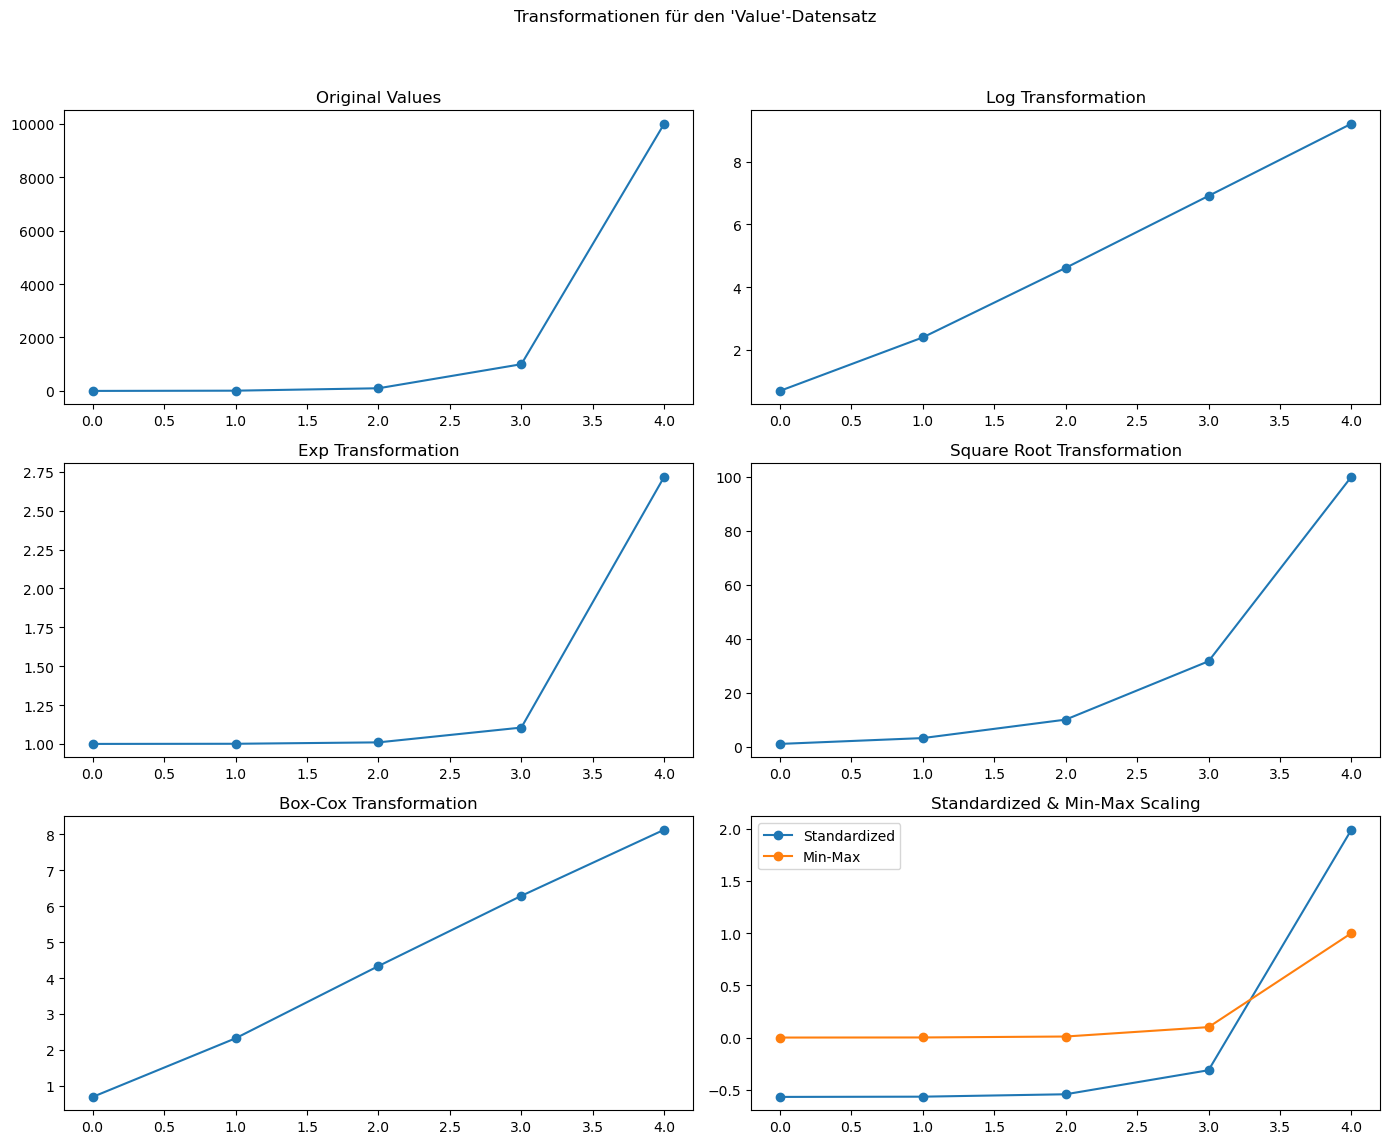

In [47]:
# Beispiel-Datensatz
dat = pd.DataFrame({'Value': [1, 10, 100, 1000, 10000]})

# Transformationen anwenden
dat['Log'] = np.log(dat['Value'] + 1)            # Log-Transformation
dat['Exp'] = np.exp(dat['Value'] / 10000)        # Exp-Transformation, skaliert für angemessene Werte
dat['Sqrt'] = np.sqrt(dat['Value'])              # Quadratwurzel-Transformation
dat['BoxCox'], _ = boxcox(dat['Value'] + 1)      # Box-Cox-Transformation (nur positive Werte)

# Normalisierung (Standardisierung und Min-Max-Skalierung)
scaler = StandardScaler()
dat['Standardized'] = scaler.fit_transform(dat[['Value']])
min_max_scaler = MinMaxScaler()
dat['MinMax'] = min_max_scaler.fit_transform(dat[['Value']])

# Plots erstellen
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Transformationen für den 'Value'-Datensatz")

# Original
axes[0, 0].plot(dat['Value'], marker='o')
axes[0, 0].set_title("Original Values")

# Log-Transformation
axes[0, 1].plot(dat['Log'], marker='o')
axes[0, 1].set_title("Log Transformation")

# Exp-Transformation
axes[1, 0].plot(dat['Exp'], marker='o')
axes[1, 0].set_title("Exp Transformation")

# Quadratwurzel-Transformation
axes[1, 1].plot(dat['Sqrt'], marker='o')
axes[1, 1].set_title("Square Root Transformation")

# Box-Cox-Transformation
axes[2, 0].plot(dat['BoxCox'], marker='o')
axes[2, 0].set_title("Box-Cox Transformation")

# Standardisierung und Min-Max-Skalierung zum Vergleich
axes[2, 1].plot(dat['Standardized'], marker='o', label="Standardized")
axes[2, 1].plot(dat['MinMax'], marker='o', label="Min-Max")
axes[2, 1].legend()
axes[2, 1].set_title("Standardized & Min-Max Scaling")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 5. Feature Selection

### Filter Methode: Korrelation

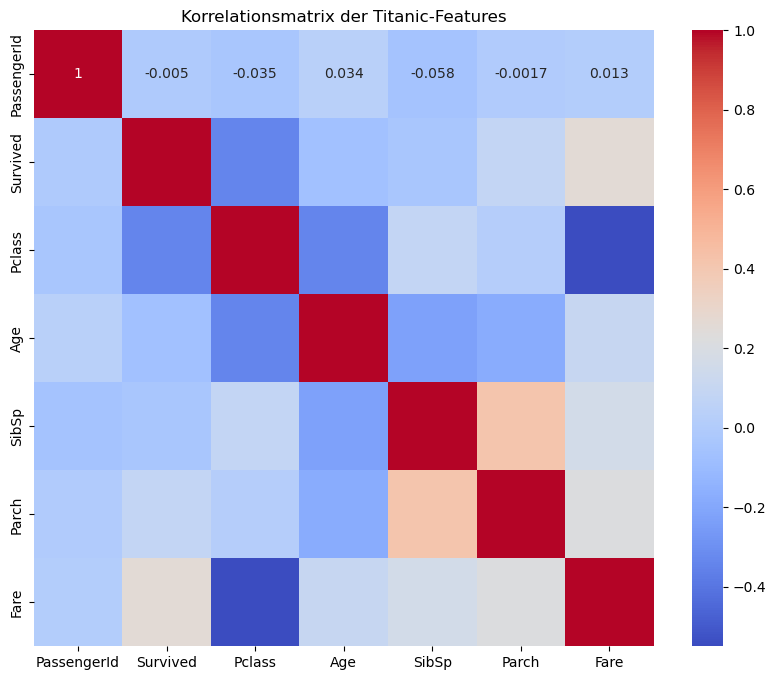

In [48]:
# Entfernen aller nicht-numerischen Spalten, um die Korrelationsmatrix berechnen zu können
data_numeric = data.select_dtypes(include=[np.number])

# Berechnen der Korrelationsmatrix
corr_matrix = data_numeric.corr()

# Anzeigen der gesamten Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Korrelationsmatrix der Titanic-Features")
plt.show()

In [49]:
# Auswahl der Features mit hoher Korrelation zur Zielvariable 'survived'
# Wir setzen eine Schwelle von |0.1| als Beispiel
target_corr = corr_matrix['Survived'].drop('Survived')  # 'survived' zu sich selbst ignorieren
high_corr_features = target_corr[abs(target_corr) >= 0.1].index.tolist()

print("Features mit hoher Korrelation zu 'Survived':", high_corr_features)

# Datensatz nur mit den ausgewählten Features und der Zielvariable
X_corr_selected = data_numeric[high_corr_features]
y_corr_selected = data_numeric['Survived']

Features mit hoher Korrelation zu 'Survived': ['Pclass', 'Fare']


### Filter für kategorische Variablen: Chi-Quadrat

In [61]:
# Bereiten wir eine Liste vor, die die Chi-Quadrat-Werte und die p-Werte enthält.
chi2_scores = []

# Berechnung der Chi-Quadrat-Werte für jedes Merkmal
for feature in X.columns:
    # Erstellen wir eine Kontingenztabelle
    contingency_table = pd.crosstab(X[feature], y)
    
    # Chi-Quadrat-Test durchführen
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    
    # Fügen wir den Namen des Merkmals, den Chi-Quadrat-Wert und den p-Wert an die Liste an.
    chi2_scores.append((feature, chi2_stat, p))

# Ergebnisse in einen DataFrame umwandeln
chi2_results = pd.DataFrame(chi2_scores, columns=['Feature', 'Chi2 Score', 'P-Value'])

# Sortieren nach Chi-Quadrat-Wert
chi2_results = chi2_results.sort_values(by='Chi2 Score', ascending=False).reset_index(drop=True)

print("Chi-Square Scores and P-Values of Features:")
print(chi2_results)

Chi-Square Scores and P-Values of Features:
    Feature  Chi2 Score       P-Value
0       Sex  258.426610  3.779910e-58
1    Pclass  100.980407  1.181362e-22
2     SibSp   37.741348  1.262014e-06
3     Parch   28.400619  7.896497e-05
4  Embarked   26.489150  1.769922e-06


### Wrapper: RFE

In [62]:
# Nur relevante Spalten auswählen und nicht numerische Spalten in numerische Daten umwandeln
data = data[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]
data = data.dropna()  # Zeilen mit fehlenden Werten entfernen

# Kategorische Variablen kodieren (Label-Encoding)
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data['Embarked'] = label_encoder.fit_transform(data['Embarked'])

# Ziel- und Merkmalsdaten festlegen
X = data.drop(columns=['Survived'])
y = data['Survived']

# RFE mit einem Entscheidungsbaum als Modell
decision_tree = DecisionTreeClassifier()
rfe_selector = RFE(estimator=decision_tree, n_features_to_select=3)  # Wähle die 3 besten Features
X_rfe_selected = rfe_selector.fit_transform(X, y)

# Anzeigen der ausgewählten Features
selected_features = X.columns[rfe_selector.get_support()]
print("Ausgewählte Features mit RFE und Entscheidungsbaum:", selected_features)

Ausgewählte Features mit RFE und Entscheidungsbaum: Index(['Pclass', 'Sex', 'Parch'], dtype='object')


### Wrapper: Vorwärts- / Rückwärtselimination

In [63]:
def forward_selection(X, y, model):
    selected_features = []
    best_score = 0

    for _ in range(X.shape[1]):
        scores_with_candidates = []
        remaining_features = [f for f in X.columns if f not in selected_features]
        
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            score = cross_val_score(model, X[candidate_features], y, cv=5).mean()
            scores_with_candidates.append((score, feature))
        
        scores_with_candidates.sort(reverse=True)
        best_candidate_score, best_candidate = scores_with_candidates[0]
        
        if best_candidate_score > best_score:
            selected_features.append(best_candidate)
            best_score = best_candidate_score
        else:
            break
    
    return selected_features

In [64]:
# Vorwärtselimination mit einem Entscheidungsbaum
model = DecisionTreeClassifier()
selected_features_forward = forward_selection(X, y, model)
print("Ausgewählte Features (Vorwärtselimination):", selected_features_forward)

Ausgewählte Features (Vorwärtselimination): ['Sex', 'SibSp']


In [65]:
def backward_elimination(X, y, model):
    selected_features = list(X.columns)
    best_score = cross_val_score(model, X[selected_features], y, cv=5).mean()
    
    for _ in range(len(selected_features) - 1):
        scores_with_candidates = []
        
        for feature in selected_features:
            candidate_features = [f for f in selected_features if f != feature]
            score = cross_val_score(model, X[candidate_features], y, cv=5).mean()
            scores_with_candidates.append((score, feature))
        
        scores_with_candidates.sort(reverse=True)
        best_candidate_score, worst_feature = scores_with_candidates[0]
        
        if best_candidate_score >= best_score:
            selected_features.remove(worst_feature)
            best_score = best_candidate_score
        else:
            break
    
    return selected_features

In [66]:
# Rückwärtselimination mit einem Entscheidungsbaum
selected_features_backward = backward_elimination(X, y, model)
print("Ausgewählte Features (Rückwärtselimination):", selected_features_backward)

Ausgewählte Features (Rückwärtselimination): ['Pclass', 'Sex', 'Embarked']
